In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
from tqdm import tqdm

In [14]:
# Rewrite Files for better response times and better analysis options

data_generated="26072020"
directory = "historic_"+data_generated

# get all dates
filename = directory+"/"+"us_deaths_1.csv"
data = pd.read_csv( filename, parse_dates=['Date'], dayfirst=False) 
data = data[data.Population>0]
dates = data['Date'].unique().copy()
dates_str = [pd.to_datetime(i).date().strftime("%Y-%m-%d") for i in dates]
us_states = data['Province/State'].unique()
tuples = [(d1,state,d2) for d1 in dates for state in us_states for d2 in dates]
index = pd.MultiIndex.from_tuples(tuples)
df = pd.DataFrame( 0, index=index, columns=["Case","Delay"])
df.sort_index(inplace=True)

for days_ago in tqdm(range(100,0,-1)):
    filename = directory+"/"+"us_deaths_"+str(days_ago)+".csv"
    # data has one row per day for all counties
    data = pd.read_csv( filename, parse_dates=True, dayfirst=False) 
    # remove lines with 0 population
    data = data[data.Population>0]
    all_state_data = data[['Province/State','Date','Case']].groupby(['Province/State','Date']).sum()
    idx = pd.IndexSlice
    #print(s_data.loc[idx['Alabama',pd.to_datetime('2020-01-22')],'Case'])
    #print(s_data.loc[idx['Alabama',:],'Case'].tolist()) 
    # which date is this file from
    csv_date = data['Date'].max()
    # loop through the data
    for state in us_states:
        for date, date_str in zip(dates, dates_str):
            try:
                idx_s = pd.IndexSlice
                idx_t = pd.IndexSlice
                cases = all_state_data.loc[idx_s[state,date_str],'Case']
                df.loc[idx_t[csv_date,state,date],'Case'] = cases
            except KeyError as e:
                pass

df.to_pickle("historical_state_cases.pickle")

100%|██████████| 100/100 [11:17<00:00,  6.77s/it]


100%|██████████| 56/56 [02:37<00:00,  2.80s/it]


done


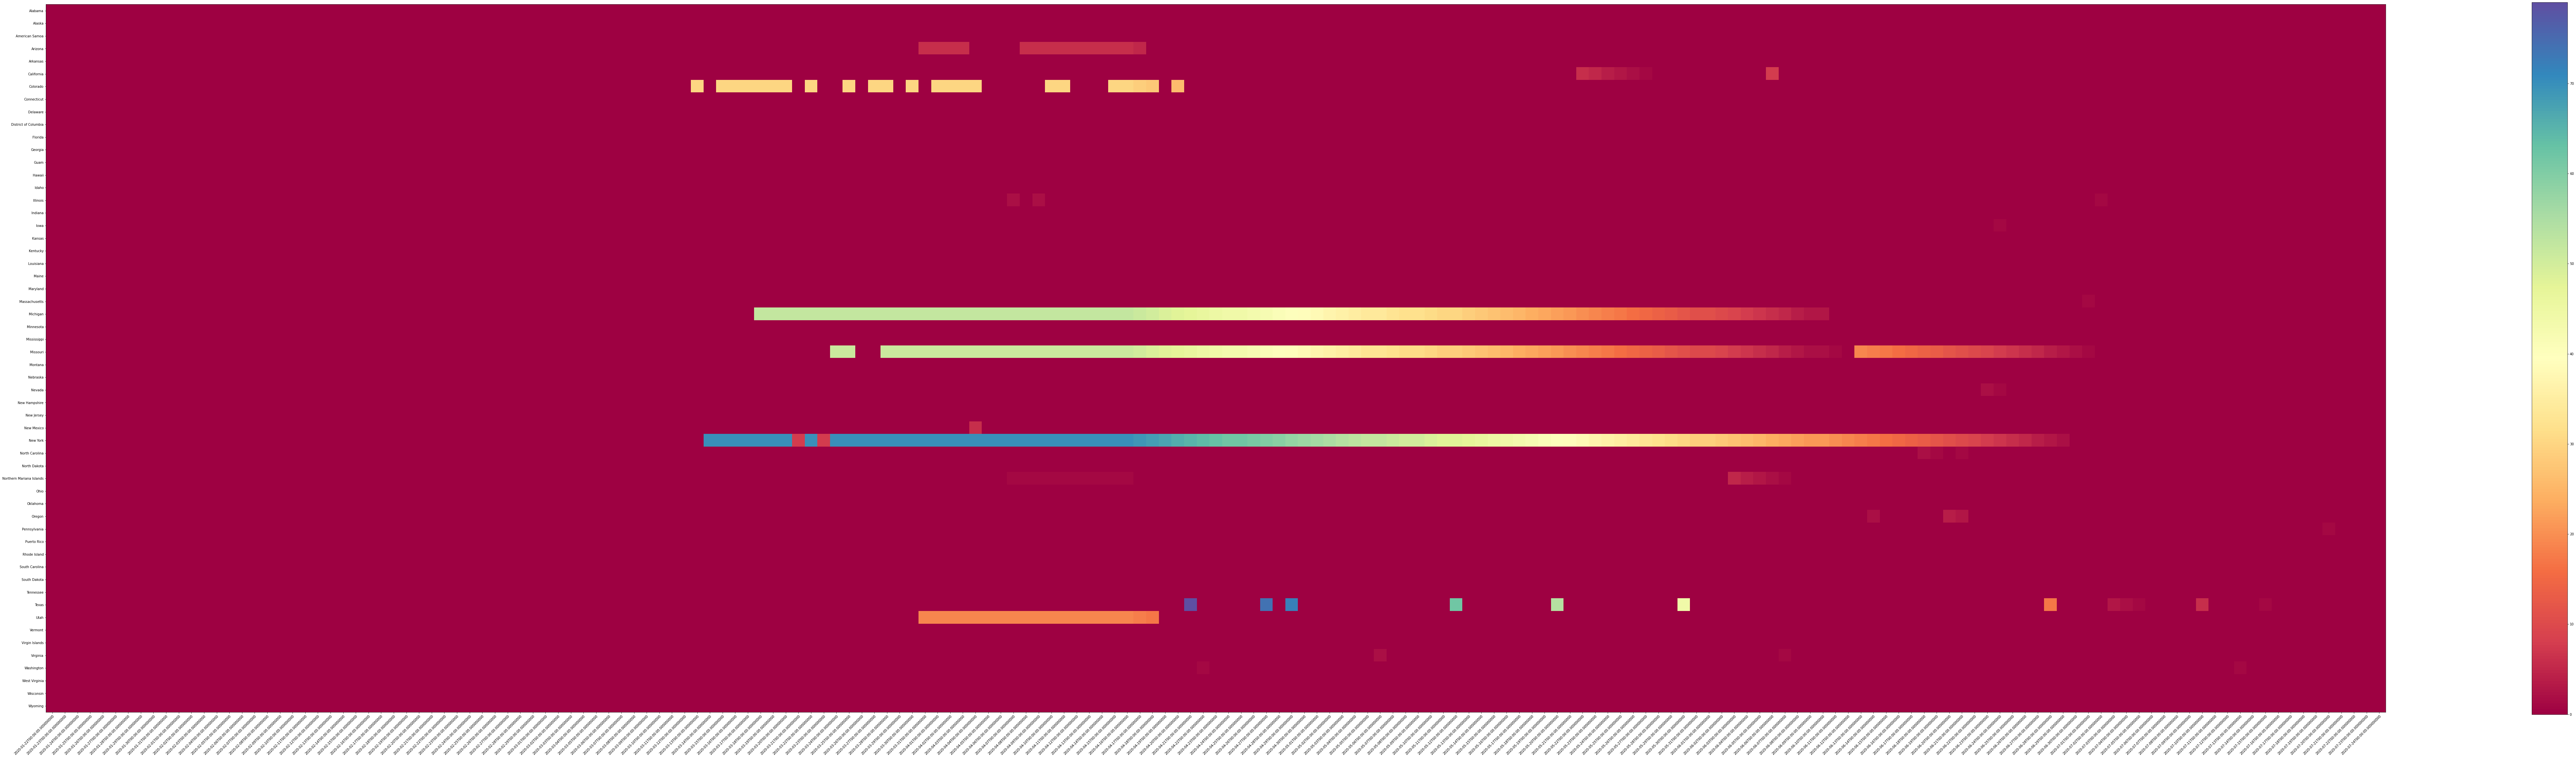

In [15]:
df = pd.read_pickle("historical_state_cases.pickle")
dates = df.index.levels[0].values
us_states = df.index.levels[1].values

dpd=[]
for us_state in tqdm(us_states):
    d_array = []
    for date in dates:
        # get all date we have for this day
        idx = pd.IndexSlice
        s_data = df.loc[idx[:,us_state,date],'Case'].tolist()
        # get rid of zeroes
        s_data = [i for i in s_data if i!=0]
        if len(s_data)>0:
            # get last number and delete all these numbers
            l_val = s_data[-1]
            s_data = [i for i in s_data if i!=l_val]
            # len of the remaining data tell us after how many days
            # the value was changed the last time
        d_array.append(len(s_data))
    dpd.append(d_array)
    

fig, ax = plt.subplots()
im = ax.imshow(dpd, cmap="Spectral")

# We want to show all ticks...
ax.set_xticks(np.arange(len(dates)))
ax.set_yticks(np.arange(len(us_states)))
# ... and label them with the respective list entries
ax.set_xticklabels(dates)
ax.set_yticklabels(us_states)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fig.colorbar(im)

# Loop over data dimensions and create text annotations.
#for i in range(len(us_states)):
#    for j in range(len(dates)):
#        text = ax.text(j, i, dpd[i, j],
#                       ha="center", va="center", color="w")


fig = plt.gcf()
fig.set_size_inches(160, 40)
fig.savefig('d.jpeg', dpi=100)
print("done")

In [18]:
df = pd.read_pickle("historical_state_cases.pickle")
dt1 = pd.to_datetime('2020-06-10')
dt2 = pd.to_datetime('2020-07-31')
idx = pd.IndexSlice
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df.loc[idx[dt1:dt2,'New York',dt1:dt2],'Case'])

2020-06-10  New York  2020-06-10    30542.0
                      2020-06-11        0.0
                      2020-06-12        0.0
                      2020-06-13        0.0
                      2020-06-14        0.0
                      2020-06-15        0.0
                      2020-06-16        0.0
                      2020-06-17        0.0
                      2020-06-18        0.0
                      2020-06-19        0.0
                      2020-06-20        0.0
                      2020-06-21        0.0
                      2020-06-22        0.0
                      2020-06-23        0.0
                      2020-06-24        0.0
                      2020-06-25        0.0
                      2020-06-26        0.0
                      2020-06-27        0.0
                      2020-06-28        0.0
                      2020-06-29        0.0
                      2020-06-30        0.0
                      2020-07-01        0.0
                      2020-07-02